# 最大似然估计(MLEs)

By Delaney Granizo-Mackenzie and Andrei Kirilenko developed as part of the Masters of Finance curriculum at MIT Sloan.

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License.

---

在本教程中，我们将做以下事情:
1. 计算正态分布的MLE。
2. 计算指数分布的MLE。
3. 使用MLE对资产收益进行正态分布拟合。

首先，我们需要导入一些库

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats

## 正态分布
我们先从正态分布中抽取一些数据。

In [2]:
TRUE_MEAN = 40
TRUE_STD = 10
X = np.random.normal(TRUE_MEAN, TRUE_STD, 1000)

现在，我们将定义函数，根据我们的数据，计算正态分布的$\mu$和$\sigma$参数的MLE。

回想一下,

$$\hat\mu = \frac{1}{T}\sum_{t=1}^{T} x_t$$

$$\hat\sigma = \sqrt{\frac{1}{T}\sum_{t=1}^{T}{(x_t - \hat\mu)^2}}$$

In [3]:
def normal_mu_MLE(X):
    # Get the number of observations
    T = len(X)
    # Sum the observations
    s = sum(X)
    return 1.0/T * s

def normal_sigma_MLE(X):
    T = len(X)
    # Get the mu MLE
    mu = normal_mu_MLE(X)
    # Sum the square of the differences
    s = sum( np.power((X - mu), 2) )
    # Compute sigma^2
    sigma_squared = 1.0/T * s
    return math.sqrt(sigma_squared)

现在，让我们在样本数据上尝试我们的函数，看看它们与内置的`np.mean`和`np.std`有什么不同

In [4]:
print("Mean Estimation") 
print (normal_mu_MLE(X))
print (np.mean(X))
print("Standard Deviation Estimation") 
print(normal_sigma_MLE(X)) 
print(np.std(X)) 

Mean Estimation
40.03582632051579
40.03582632051582
Standard Deviation Estimation
9.701136664153747
9.701136664153745


现在，让我们使用内置的`fit()`函数一次性估计这两个参数。

In [8]:
mu, std = scipy.stats.norm.fit(X)
print("mu estimate: " ,mu)
print("std estimate: " ,std)

mu estimate:  40.03582632051582
std estimate:  9.701136664153745


现在，让我们将分布PDF与数据一起绘制，以查看它是否适合。我们可以通过访问`scipy.stats.normal.pdf`中提供的pdf来实现这一点。

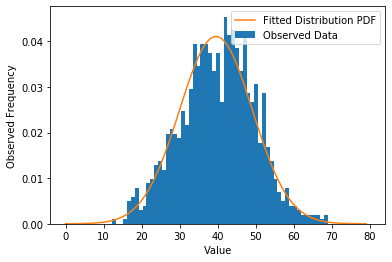

In [7]:
# We would like to plot our data along an x-axis ranging from 0-80 with 80 intervals
# (increments of 1)
x = np.linspace(0, 80, 80)
plt.hist(X, bins=x, density='true')
plt.plot(scipy.stats.norm.pdf(x, loc=mu, scale=std))
plt.xlabel('Value')
plt.ylabel('Observed Frequency')
plt.legend(['Fitted Distribution PDF', 'Observed Data' ]);

## 指数分布
我们对指数分布做同样的事情。我们先抽样一些数据。

In [9]:
TRUE_LAMBDA = 5
X = np.random.exponential(TRUE_LAMBDA, 1000)

`numpy`将指数分布定义为
$$\frac{1}{\lambda}e^{-\frac{x}{\lambda}}$$

所以我们需要把课堂笔记中的MLE倒过来。在这里

$$\hat\lambda = \frac{T}{\sum_{t=1}^{T} x_t}$$

这是它的倒数

$$\hat\lambda = \frac{\sum_{t=1}^{T} x_t}{T}$$

In [10]:
def exp_lamda_MLE(X):
    T = len(X)
    s = sum(X)
    return s/T

In [11]:
print("lambda estimate: " ,exp_lamda_MLE(X)) 

lambda estimate:  5.151819583062726


In [12]:
# The scipy version of the exponential distribution has a location parameter
# that can skew the distribution. We ignore this by fixing the location
# parameter to 0 with floc=0
_, l = scipy.stats.expon.fit(X, floc=0)

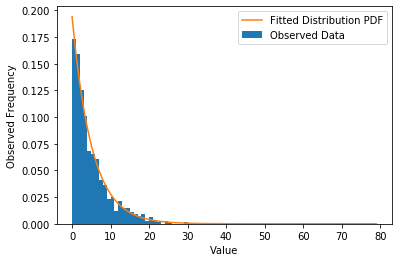

In [14]:
x = range(0, 80)
plt.hist(X, bins=x, density='true')
plt.plot(scipy.stats.expon.pdf(x, loc=0,scale=l))
plt.xlabel('Value')
plt.ylabel('Observed Frequency')
plt.legend(['Fitted Distribution PDF', 'Observed Data', ]);

## MLE表示资产回报

现在，我们将获取一些实际的回报，并尝试使用MLE来拟合正态分布。

In [16]:
from pandas_datareader import data
prices = data.get_data_yahoo('TSLA', start='2014-01-01', end='2015-01-01')['Close']
# This will give us the number of dollars returned each day
absolute_returns = np.diff(prices)
# This will give us the percentage return over the last day's value
# the [:-1] notation gives us all but the last item in the array
# We do this because there are no returns on the final price in the array.
returns = absolute_returns/prices[:-1]

让我们使用`scipy`的fit函数来获得$\mu$和$\sigma$ 的MLEs。

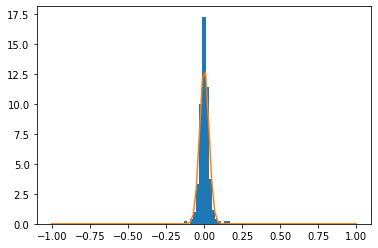

In [17]:
mu, std = scipy.stats.norm.fit(returns)
x = np.linspace(-1,1, num=100)
h = plt.hist(returns, bins=x, density='true')
l = plt.plot(x, scipy.stats.norm.pdf(x, loc=mu, scale=std))

当然，除非我们首先检验过它们是否服从正态分布，否则这种契合是没有意义的。我们可以用Jarque-Bera正态性检验来验证。如果p值低于c, Jarque-Bera检验将拒绝正态分布的假设。

In [18]:
from statsmodels.stats.stattools import jarque_bera
jarque_bera(returns)

(253.65129069336803,
 8.323808154414191e-56,
 0.7543640587034445,
 7.677713677435444)

In [19]:
jarque_bera(np.random.normal(0, 1, 100))

(0.051331282461143546,
 0.9746609215596712,
 -0.016049451148402796,
 2.8937495022975677)